[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luleu96/GenAIinDD_Exercises/blob/work/Exercises/Exercise_1/OHE.ipynb)

[Source: TeachOpenCADD T021](https://projects.volkamerlab.org/teachopencadd/talktorials/T021_one_hot_encoding.html)

In [13]:
!pip install rdkit

In [14]:
from warnings import filterwarnings

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# Silence some expected warnings
filterwarnings("ignore")


In [15]:
# load CHEMBL25 datset for EGFR activities

df = pd.read_csv("/content/CHEMBL25_activities_EGFR.csv", index_col=0).reset_index(drop=True)
print(f"Shape of dataframe: {df.shape}\n")


Shape of dataframe: (3905, 5)



In [17]:
df.head(10)

,chembl_id,IC50,units,canonical_smiles,pIC50
0,CHEMBL207869,77.0,nM,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,7.113509
1,CHEMBL3940060,330.0,nM,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,6.481486
2,CHEMBL3678951,1.0,nM,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,9.000000


In [18]:
df = df[["chembl_id", "canonical_smiles"]]

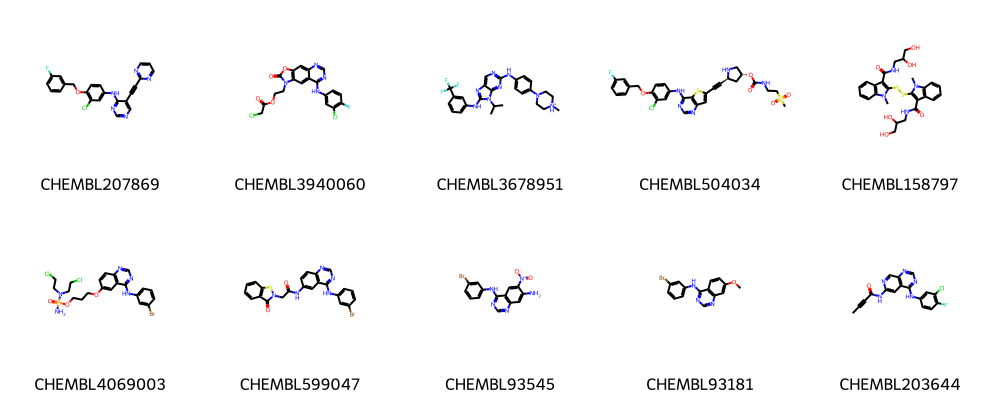

In [19]:
# drawing a subset of our dataset
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="canonical_smiles", molCol="Mol2D")
Draw.MolsToGridImage(list(df.Mol2D[0:10]), legends=list(df.chembl_id[0:20]), molsPerRow=5)

In [20]:
# search for double letter elements in SMILES string and replace it with a arbitrary single character

def assess_two_letter_elements(df):
    """
    Find the two letter elements in dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe which requires preprocessing.

    Returns
    -------
    two_letter_elements : list
        List with found two letter elements
    """

    # Search for unique characters in SMILES strings
    unique_chars = set(df.canonical_smiles.apply(list).sum())
    # Get upper and lower case letters only
    upper_chars = []
    lower_chars = []
    for entry in unique_chars:
        if entry.isalpha():
            if entry.isupper():
                upper_chars.append(entry)
            elif entry.islower():
                lower_chars.append(entry)
    print(f"Upper letter characters {sorted(upper_chars)}")
    print(f"Lower letter characters {sorted(lower_chars)}")

    # List of all possible periodic elements
    periodic_elements = [
        "Ac",
        "Al",
        "Am",
        "Sb",
        "Ar",
        "As",
        "At",
        "Ba",
        "Bk",
        "Be",
        "Bi",
        "Bh",
        "B",
        "Br",
        "Cd",
        "Ca",
        "Cf",
        "C",
        "Ce",
        "Cs",
        "Cl",
        "Cr",
        "Co",
        "Cn",
        "Cu",
        "Cm",
        "Ds",
        "Db",
        "Dy",
        "Es",
        "Er",
        "Eu",
        "Fm",
        "Fl",
        "F",
        "Fr",
        "Gd",
        "Ga",
        "Ge",
        "Au",
        "Hf",
        "Hs",
        "He",
        "Ho",
        "H",
        "In",
        "I",
        "Ir",
        "Fe",
        "Kr",
        "La",
        "Lr",
        "Pb",
        "Li",
        "Lv",
        "Lu",
        "Mg",
        "Mn",
        "Mt",
        "Md",
        "Hg",
        "Mo",
        "Mc",
        "Nd",
        "Ne",
        "Np",
        "Ni",
        "Nh",
        "Nb",
        "N",
        "No",
        "Og",
        "Os",
        "O",
        "Pd",
        "P",
        "Pt",
        "Pu",
        "Po",
        "K",
        "Pr",
        "Pm",
        "Pa",
        "Ra",
        "Rn",
        "Re",
        "Rh",
        "Rg",
        "Rb",
        "Ru",
        "Rf",
        "Sm",
        "Sc",
        "Sg",
        "Se",
        "Si",
        "Ag",
        "Na",
        "Sr",
        "S",
        "Ta",
        "Tc",
        "Te",
        "Ts",
        "Tb",
        "Tl",
        "Th",
        "Tm",
        "Sn",
        "Ti",
        "W",
        "U",
        "V",
        "Xe",
        "Yb",
        "Y",
        "Zn",
        "Zr",
    ]

    # The two_char_elements list contains all two letter elements
    # which can be generated by all possible combination of upper x lower characters
    # and are valid periodic elements.
    two_char_elements = []
    for upper in upper_chars:
        for lower in lower_chars:
            ch = upper + lower
            if ch in periodic_elements:
                two_char_elements.append(ch)

    # This list is then reduced to the subset of two-letter elements
    # that actually appear in the SMILES strings, specific to our data set.
    two_char_elements_smiles = set()
    for char in two_char_elements:
        if df.canonical_smiles.str.contains(char).any():
            two_char_elements_smiles.add(char)

    return two_char_elements_smiles

In [21]:
elements_found = assess_two_letter_elements(df)
print(f"\nTwo letter elements found in the data set: {sorted(elements_found)}")

Upper letter characters ['B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S']
Lower letter characters ['c', 'e', 'l', 'n', 'o', 'r', 's']

Two letter elements found in the data set: ['Br', 'Cl', 'Cn', 'Sc', 'Se']


In [22]:
# double character elements that will be replaced
replace_dict = {"Cl": "L", "Br": "R", "Se": "X", "@@": "Z"}

In [23]:
# replace double character elements

def preprocessing_data(df, replacement):
    """
    Preprocess the SMILES structures in a data set.

    Parameters
    ----------
    df : pandas.DataFrame
      Dataframe which requires preprocessing.
    replacement : dict
      Dictionary with mapping for replacement.

    Returns
    -------
    df : pandas.DataFrame
        Dataframe with new processed canonical SMILES column.
    unique_char : list
        List with unique characters present in SMILES.
    """
    # Print warning if the data set has a 'Sc' element
    if df.canonical_smiles.str.contains("Sc").any():
        print(
            'Warning: "Sc" element is found in the data set, since the element is rarely found '
            "in the drugs so we are not converting  "
            'it to single letter element, instead considering "S" '
            'and "c" as separate elements. '
        )

    # Create a new column having processed canonical SMILES
    df["processed_canonical_smiles"] = df["canonical_smiles"].copy()

    # Replace the two letter elements found with one character
    for pattern, repl in replacement.items():
        df["processed_canonical_smiles"] = df["processed_canonical_smiles"].str.replace(
            pattern, repl
        )

    unique_char = set(df.processed_canonical_smiles.apply(list).sum())
    return df, unique_char

In [24]:
df, unique_char = preprocessing_data(df, replace_dict)
df.head(10)

,chembl_id,canonical_smiles,Mol2D,processed_canonical_smiles
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,<rdkit.Chem.rdchem.Mol object at 0x7d9dbe4afed0>,Lc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,<rdkit.Chem.rdchem.Mol object at 0x7d9dbe4afe60>,LCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(L)c(F)cc3)ncn...
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,<rdkit.Chem.rdchem.Mol object at 0x7d9dbe4afdf0>,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...


In [25]:
# Print unique characters
print(f"All unique characters found in the preprocessed data set:\n{sorted(unique_char)}")

All unique characters found in the preprocessed data set:
['#', '(', ')', '+', '-', '/', '0', '1', '2', '3', '4', '5', '6', '7', '=', '@', 'B', 'C', 'F', 'H', 'I', 'L', 'N', 'O', 'P', 'R', 'S', 'X', 'Z', '[', '\\', ']', 'c', 'n', 'o', 's']


In [26]:
# Index of the longest SMILES string
longest_smiles = max(df["canonical_smiles"], key=len)
longest_smiles_index = df.canonical_smiles[df.canonical_smiles == longest_smiles].index.tolist()
print(f"Longest SMILES: {longest_smiles}")
print(f"Contains {len(longest_smiles)} characters, index in dataframe: {longest_smiles_index[0]}.")
smiles_maxlen = len(longest_smiles)
# NBVAL_CHECK_OUTPUT

Longest SMILES: O=C(N[C@@H]1C(=O)N[C@H](CCC[NH3+])C(=O)N[C@@H]([C@H](CC)C)C(=O)N[C@H](Cc2ccccc2)C(=O)N[C@@H](Cc2[nH]cnc2)C(=O)N[C@H](CC(=O)[O-])C(=O)N[C@@H](CC(=O)N)C(=O)NCCCC1)[C@@H](NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@H]1N=C([C@@H]([NH3+])[C@H](CC)C)SC1)CC(C)C)CCC(=O)[O-])[C@H](CC)C
Contains 267 characters, index in dataframe: 2704.


In [27]:
# Index of the shortest SMILES string
shortest_smiles = min(df["canonical_smiles"], key=len)
shortest_smiles_index = df.canonical_smiles[df.canonical_smiles == shortest_smiles].index.tolist()
print(f"Shortest SMILES: {shortest_smiles}")
print(
    f"Contains {len(shortest_smiles)} characters, index in dataframe: {shortest_smiles_index[0]}."
)

Shortest SMILES: Oc1c(O)cccc1
Contains 12 characters, index in dataframe: 3428.


In [28]:
# Function defined to create one-hot encoded matrix
def smiles_encoder(smiles, max_len, unique_char):
    """
    Function defined using all unique characters in our
    processed canonical SMILES structures created
    with the preprocessing_data function.

    Parameters
    ----------
    smiles : str
         SMILES of a molecule in string format.
    unique_char : list
         List of unique characters in the string data set.
    max_len : int
         Maximum length of the SMILES string.

    Returns
    -------
    smiles_matrix : numpy.ndarray
         One-hot encoded matrix of fixed shape
         (unique char in smiles, max SMILES length).
    """
    # create dictionary of the unique char data set
    smi2index = {char: index for index, char in enumerate(unique_char)}
    # one-hot encoding
    # zero padding to max_len
    smiles_matrix = np.zeros((len(unique_char), max_len))
    for index, char in enumerate(smiles):
        smiles_matrix[smi2index[char], index] = 1
    return smiles_matrix

In [29]:
# Apply the function to the processed canonical SMILES strings
df["unique_char_ohe_matrix"] = df["processed_canonical_smiles"].apply(
    smiles_encoder, max_len=smiles_maxlen, unique_char=unique_char
)
df.head(3)

,chembl_id,canonical_smiles,Mol2D,processed_canonical_smiles,unique_char_ohe_matrix
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,<rdkit.Chem.rdchem.Mol object at 0x7d9dbe4afed0>,Lc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,<rdkit.Chem.rdchem.Mol object at 0x7d9dbe4afe60>,LCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(L)c(F)cc3)ncn...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,<rdkit.Chem.rdchem.Mol object at 0x7d9dbe4afdf0>,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [30]:
def one_hot_matrix_plot(ohe_matrix, smiles_char, smiles):
    """
    Visualize one-hot encoded matrix
    using matplotlib imshow() function.

    Parameters
    ----------
    ohe_matrix : numpy.ndarray
       One-hot encoded (ohe) matrix of shape
       (`smiles_char`, `len(smiles)`).
    smiles_char : list
        List of all possible SMILES characters.
    smiles : string
        Original SMILES string of respective molecule.

    Returns
    ------
    None

    """
    im = plt.imshow(ohe_matrix, cmap="hot", interpolation="None")
    plt.xlabel("Length of SMILES string")
    plt.ylabel(f"Char in SMILES ({len(smiles_char)})")
    plt.title("Visualization of one-hot encoded matrix")
    plt.show()
    print("Shape of one-hot matrix : ", ohe_matrix.shape)
    print("Associated canonical SMILES: ", smiles)
    return None

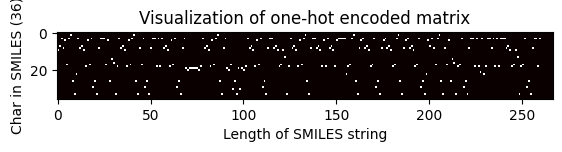

Shape of one-hot matrix :  (36, 267)
Associated canonical SMILES:  O=C(N[C@@H]1C(=O)N[C@H](CCC[NH3+])C(=O)N[C@@H]([C@H](CC)C)C(=O)N[C@H](Cc2ccccc2)C(=O)N[C@@H](Cc2[nH]cnc2)C(=O)N[C@H](CC(=O)[O-])C(=O)N[C@@H](CC(=O)N)C(=O)NCCCC1)[C@@H](NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@H]1N=C([C@@H]([NH3+])[C@H](CC)C)SC1)CC(C)C)CCC(=O)[O-])[C@H](CC)C


In [31]:
# Pass the index of the longest SMILES string to visualize the matrix
one_hot_matrix_plot(
    df.iloc[longest_smiles_index[0]]["unique_char_ohe_matrix"], unique_char, longest_smiles
)

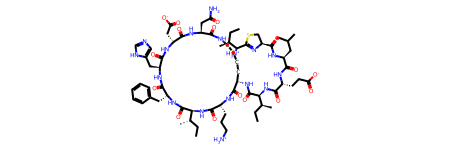

In [32]:
# Draw the molecules with the longest SMILES
longest_smiles_mol = Chem.MolFromSmiles(longest_smiles)
longest_smiles_mol

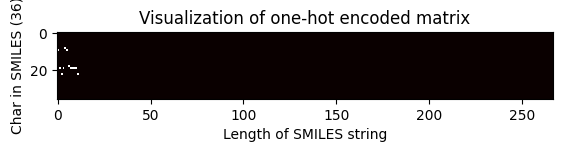

Shape of one-hot matrix :  (36, 267)
Associated canonical SMILES:  Oc1c(O)cccc1


In [33]:
# Pass the index of the shortest SMILES string to visualize the matrix
one_hot_matrix_plot(
    df.iloc[shortest_smiles_index[0]]["unique_char_ohe_matrix"], unique_char, shortest_smiles
)

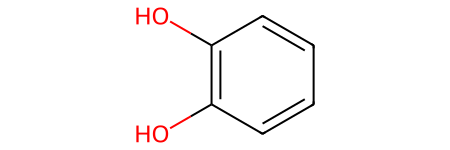

In [34]:
# Draw the molecules with the shortest SMILES
shortest_smiles_mol = Chem.MolFromSmiles(shortest_smiles)
shortest_smiles_mol

In [35]:
# Print the some rows of the matrix for the molecule with the longest smiles
np.set_printoptions(threshold=np.inf)
subset = 3
unique_char = list(unique_char)
print(
    f"First {subset} rows of the ohe matrix, representing the characters {unique_char[0:subset]}\n"
)
print(np.matrix(df.iloc[longest_smiles_index[0]]["unique_char_ohe_matrix"])[0:subset, :])

First 3 rows of the ohe matrix, representing the characters ['o', 'Z', '0']

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 